In [1]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial.distance import cdist
import numpy as np
import cv2
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML


# Change to approapriate color map for gray scale images
plt.rcParams['image.cmap'] = 'gray'

# Color palette used to differentiate line clusters
GROUP_COLORS = \
{
    0 : (255,255,255),
    1 : (255,0,0),
    2 : (0,255,0),
    3 : (0,0,255),
    4 : (255,255,0),
    5 : (255,0,255),
    6 : (0,255,255),
    7 : (0,0,0),
    8 : (255,127,0),
    9 : (127,255,0),
    10: (127,0,255),
    11: (127,127,127),
}


In [2]:
# Returns image truncated  to given bounds
def slice(image, bounds):
    sliced = image[bounds[1]:bounds[1]+bounds[3], bounds[0]:bounds[0]+bounds[2]]
    return (sliced)


In [3]:
# Returns min distance map (as grey scale) to an array of target colors
def distance_map(image, threshold=127, colors=np.array([[245, 171, 48], [255, 255, 255]], np.uint8)):
    flat = image.reshape(-1, 3)
    d_field = cdist(flat, colors)
    d_field_thres = np.insert(d_field, 0, threshold, axis=1)
    d_field_min = 255 - np.amin(d_field_thres, 1)
    return d_field_min.astype(np.uint8).reshape(image.shape[0], image.shape[1])

In [4]:
# Converts rgb image to grayscale
def rgb_to_gray(image):
    # Grayscale conversion
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


In [5]:
# Converts grayscale image to rgb
def gray_to_rgb(image):
    # RGB conversion
    return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

In [6]:
# Blends two images into each other 
def combine(image1, image2, weight1=0.5, weight2=0.5):
    return cv2.addWeighted(image1, weight1, image2, weight2, 0) 

In [7]:
# Blurrs an image
def blur(image, kernel_size = 5):
    # Gaussian blurring with provided kernel size
    return cv2.GaussianBlur(image,(kernel_size, kernel_size), 0)


In [8]:
# Normalizes an image to full grayscale range given the pixels inside mask
def normalize(image, mask):
    normalized = image
    
    # Normalize all image data according to values within mask
    minmax = cv2.minMaxLoc(image, mask)
    if (minmax[1]-minmax[0]) > 0:
        alpha = 255/(minmax[1]-minmax[0])
        beta = -minmax[0]
        normalized = cv2.convertScaleAbs(image, normalized, alpha=alpha, beta=beta)
    return normalized

In [9]:
# Returns Canny Edges from image
def detect_edges(image, low_threshold=50, high_threshold=150, apertureSize=5):
    # Run edge detection with default parameters
    return cv2.Canny(image, low_threshold, high_threshold, apertureSize)


In [10]:
# Returns hough lines from image
def hough_lines(image, edges, mask, rho=1, theta=np.pi/90, threshold=10, min_line_length=40, max_line_gap=20):
    # Run Hough on edge detected image within mask
    masked_edges = cv2.bitwise_and(edges, mask)
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    return lines

In [11]:
# Calcs angle between two points (radians, -90 to 90, counter-clockwise, N=0)
def calc_angle(p1, p2):
    theta = np.arctan2(p2[0]-p1[0], p2[1]-p1[1])
    theta = theta + 0.5 * np.pi
    if theta > 0.5 * np.pi:
        theta = theta - np.pi
    return -theta

# Calcs absolute angle difference between two points (#radians, 0 to 90)
def calc_angle_dif(a1, a2):
    dif = abs(a2 - a1)
    if dif > 0.5 * np.pi:
        dif = abs(dif - np.pi)
    return abs(dif)   

# Specifies filter criteria for "filter_lines"
# 1st pass: Filter horizontal lines based on threshold
# 2nd pass: Filter lines based on vanishing point (deactivated)
def filter_criteria(line, area_of_interest, threshold):
    h = area_of_interest.height()
    min_y = area_of_interest.min_y()
    vp = area_of_interest.vp
    for x1,y1,x2,y2 in line:
        #calc line angle (-90 to +90)
        a = np.array([y1, x1], np.int32)
        b = np.array([y2, x2], np.int32)
        alpha = calc_angle(a, b)
        filterPass1 = alpha > -0.5*np.pi+threshold and alpha < 0.5*np.pi-threshold
        #if filterPass1:
        #    c = (a + b)/2
        #    gamma = calc_angle(c, vp)
        #    delta = calc_angle_dif(alpha, gamma)
        #    filterPass2 = delta < 0.5 * np.pi * ((h - c[0] + min_y) / h)**2 + threshold
        #    #print("filterpass2("+str(filterPass2)+"): "+str(int(alpha/np.pi*180))+"|"+str(int(gamma/np.pi*180))+"|"+str(int(delta/np.pi*180))+" x="+str(c[1])+" y="+ str(h - c[0]) +" f="+ str(int(90 * ((h - c[0]) / h)**2))+" t=" +str(int(threshold/np.pi*180)))
        #    return filterPass2
        return filterPass1

# Filters (Hough) lines based on "filter_criteria"
def filter_lines(lines, area_of_interest, threshold=0.05*np.pi):
    #filter by absolute angle and vanishing point orientation 
    filter = np.array([filter_criteria(line, area_of_interest, threshold) for line in lines])
    selection = lines[filter]
    return selection

In [12]:
# Represents a cluster of lines
# The cluster is represented by a mean straight line in general form Ax * By + C = 0
class LineGroup:
    # Constructs a cluster given an initial line section (p1, p2) and vertical validity range (yrange)
    def __init__(self, p1, p2, yrange, color=(255,255,255), width=1):
        pd = p2 - p1
        distance = cv2.norm(pd)
        self.yrange = yrange
        self.ma = self.na = -pd[0] / distance
        self.mb = self.nb = pd[1] / distance
        self.mc = self.nc = (pd[0] * p1[1] - pd[1] * p1[0]) / distance
        self.color = color
        self.width = width
        self.count = 1
        self.priority = 1
        
    def __lt__(self, other):
        return self.priority.__lt__(other.priority)
    
    def __repr__(self):
        p = self.get_end_points()
        return "<LineGroup p1:(%s,%s) p2:(%s,%s)>" % (p[0][1],p[0][0],p[1][1],p[1][0])

    # Returns similarity score between cluster and line section (p1, p2) based on distance and angle difference
    def get_delta(self, p1, p2):
        c = (p1 + p2) / 2
        dist = abs(self.ma * c[1] + self.mb * c[0] + self.mc)
        a1 = np.arctan2(p2[0]-p1[0], p2[1]-p1[1])
        a2 = np.arctan2(-self.ma, self.mb)
        phi = calc_angle_dif(a1, a2)
        return (dist, phi)
    
    # Returns clusters mean endpoints based on vertical range
    def get_end_points(self):
        if self.ma != 0:
            return np.array([[self.yrange[0], (-self.mc - self.yrange[0] * self.mb) / self.ma], \
                            [self.yrange[1], (-self.mc - self.yrange[1] * self.mb) / self.ma]], \
                            np.int32)
        
        self.priority = 0
        return np.array([[self.yrange[0], 0], \
                         [self.yrange[1], 9999]], \
                          np.int32)
    
    # Adds a line section (p1, p2) to the cluster, updating mean straight line
    def add_line(self, p1, p2):
        pd = (p2 - p1)
        distance = cv2.norm(pd)
        self.na = -pd[0] / distance
        self.nb = pd[1] / distance
        self.nc = (pd[0] * p1[1] - pd[1] * p1[0]) / distance
        self.count += 1
        self.priority += 1
        self.ma += (self.na - self.ma) / (self.count)
        self.mb += (self.nb - self.mb) / (self.count)
        self.mc += (self.nc - self.mc) / (self.count)
    
    # Draws most recently added line (for testing)
    def draw_newest(self, image):
        y1 = int(self.yrange[0])
        x1 = int((-self.nc - y1 * self.nb) / self.na)
        y2 = int(self.yrange[1])
        x2 = int((-self.nc - y2 * self.nb) / self.na)
        cv2.line(image, (x1, y1), (x2, y2), self.color, self.width)         

# Clusters a set of give lines, based on max distance and max angle difference
def group_lines(lines, area_of_interest, max_dist=15, max_angle_dif=0.02*np.pi, image=None):
    groups = []
    y = area_of_interest.min_y()
    h = area_of_interest.height()
    yranges = np.array([[y, y+h]], np.uint32)
    for yrange in yranges:
        ygroups = []
        if image != None:
            cv2.line(image, (area_of_interest.min_x(), yrange[0]), (area_of_interest.max_x(), yrange[0]), (127, 127, 127), 1)      
            cv2.line(image, (area_of_interest.min_x(), yrange[1]), (area_of_interest.max_x(), yrange[1]), (127, 127, 127), 1) 
        for line in lines:
            for x1,y1,x2,y2 in line:
                if max(y1, y2) > yrange[0] and min(y1, y2) < yrange[1]:
                    min_delta = 9999
                    min_group = None
                    p1 = np.array([y1, x1])
                    p2 = np.array([y2, x2])
                    for group in ygroups:
                        delta = group.get_delta(p1, p2)
                        combi_delta = delta[0] + delta[1] * (max_dist / max_angle_dif)
                        if (delta[0] < max_dist and delta[1] < max_angle_dif and combi_delta < min_delta):
                            min_delta = combi_delta
                            min_group = group
                    if min_group == None: 
                        col = GROUP_COLORS[len(ygroups) % 12]
                        ygroups.append(LineGroup(p1, p2, yrange, col, 1))
                        min_group = ygroups[-1]
                    else:
                        min_group.add_line(p1, p2)
                    if image != None:
                        min_group.draw_newest(image)
        groups.extend(ygroups)
        
    # Filter and sort
    groups = [group for group in groups if group.count > 1]
    groups.sort(reverse=True)
    return groups

In [13]:
# Selects up to two final lane lines from a list of line clusters, searching for best trapeziod
def select_lanes(groups):
    selected_lanes = (None, None)
    selected_prio = 0
    for i in range(0, len(groups) - 1):
        g1 = groups[i]
        p1 = g1.get_end_points()
        for g2 in groups[i:]:
            p2 = g2.get_end_points()
            dx1 = p2[0][1] - p1[0][1]
            dx2 = p2[1][1] - p1[1][1]
            f1 = g1.ma * g1.mb
            f2 = g2.ma * g2.mb
            if ((dx1 < 0 and dx2 < 0) or (dx1 > 0 and dx2 > 0)) \
            and ((f1 < 0 and f2 > 0) or (f1 > 0 and f2 < 0)) \
            and abs(dx2) > abs (dx1):
                # Found trapeziod
                prio = g1.priority + g2.priority
                if (prio > selected_prio):
                    selected_lanes = (p1, p2) if f1 > f2 else (p2, p1)
                    selected_prio = prio
                break
        if g1.priority < selected_prio / 2:
            break;
            
    if selected_prio == 0 and len(groups) > 0:
        f = groups[0].ma * groups[0].mb
        if f > 0:
            selected_lanes = (groups[0].get_end_points(), None)
        else:
            selected_lanes = (None, groups[0].get_end_points())
    return selected_lanes
    

In [14]:
# Draws a given hough list of lines or selected lanes over an image
def line_overlay(image, area_of_interest, lines=None, lanes=None, width=3):
    overlay = np.copy(image) 
    #area_of_interest.draw(overlay)
    vp = area_of_interest.vp
    
    if lanes != None:  
        if lanes[0] != None:
            left = lanes[0]
            cv2.line(overlay, (left[0][1], left[0][0]), (left[1][1], left[1][0]), (255,0,0), width)
        if lanes[1] != None:
            right = lanes[1]
            cv2.line(overlay, (right[0][1], right[0][0]), (right[1][1], right[1][0]), (0,0,255), width)
            
    if lines != None:    
        for line in lines:
            for x1,y1,x2,y2 in line:
                #get center point
                a = np.array([y1, x1], np.int32)
                b = np.array([y2, x2], np.int32)
                c = (a + b)/2

                #calc line angle and angle to vanishing point
                theta1 = calc_angle(a, b)
                theta2 = calc_angle(vp, c)
                
                # use delta between angles for coloring
                theta = calc_angle_dif(theta1, theta2)
                col = angle_to_color(theta, 255)
                cv2.line(overlay,(x1,y1),(x2,y2),col,width)
    return overlay

# Draws a semi-transparent  lane area over an image
def area_overlay(image, lanes):
    if (lanes[0] != None and lanes[1] != None):
        overlay = np.zeros_like(image)
        p1 = lanes[0]
        p2 = lanes[1]
        poly = np.array([[(p1[0][1], p1[0][0]),\
                          (p2[0][1], p2[0][0]),\
                          (p2[1][1], p2[1][0]),\
                          (p1[1][1], p1[1][0])]],\
                          dtype=np.int32)
        cv2.fillPoly(overlay, poly, (0, 255, 0))
        return combine(image, overlay, 1.0, 0.25)
    return image   
    

In [15]:
# Displays image in jupyter and also dumps it into a file for detailed review
def display_image(image, dump='result.jpg'):
    plt.imshow(image)
    plt.show()
    mpimg.imsave(dump, image)
    

In [16]:
# Returns an rgb value visualizing an angle
def angle_to_color(angle, maxCol):
    anorm = abs(angle)*maxCol/(0.5*np.pi)  
    blue = 0
    if angle < 0:
         blue = maxCol
    return (anorm, maxCol-anorm, blue)

# Displays some statistics regarding lines and clusters (test only)
def display_statistics(lines, groups, area_of_interest):    
    h = area_of_interest.max_y()
    vp = area_of_interest.vp
    
    if groups != None:
        print(len(groups))
    
    if lines != None:
        print(lines.shape)
        treshold = 0#0.05*np.pi
        for line in lines:
            for x1,y1,x2,y2 in line:
                a = np.array([y1, x1], np.int32)
                b = np.array([y2, x2], np.int32)
                c = (a + b)/2
                y = h - c[0]
                theta = calc_angle(a, b)
                #theta = calc_angle(vp, c)
                col = angle_to_color(theta, 1)
            plt.plot(theta/np.pi*180, y, 'r.', color=col)
            plt.plot(theta/np.pi*180, y, 'r.', color=col)
    plt.show() 
   
    if lines != None:
        print(lines.shape)     
        treshold = 0#0.05*np.pi
        for line in lines:
            for x1,y1,x2,y2 in line:
                a = np.array([y1, x1], np.int32)
                b = np.array([y2, x2], np.int32)
                c = (a + b)/2
                y = h - c[0]
                theta1 = calc_angle(a, b)
                theta2 = calc_angle(vp, c)
                theta = calc_angle_dif(theta1, theta2)
                col = angle_to_color(theta, 1)
            plt.plot(theta/np.pi*180, y, 'r.', color=col)
            plt.plot(theta/np.pi*180, y, 'r.', color=col)
    plt.show() 

In [17]:
# Represents an area of interest inside an image
# Area is represented as a clipped distorted rectangle
class AreaOfInterest:
    # Constructs an area of interest given an image size and rectangle parameters in percent
    def __init__(self, image_size, height1_p=0.16, height2_p=0.32, width_p=0.40):
        self.image_size = image_size
        h = self.image_size[0]
        w = self.image_size[1]
        self.poly = np.array([[(w * 0.5 * (1 - width_p), h * (1- height2_p)),\
                               (w * 0.5 * (1 + width_p), h * (1- height2_p)),\
                               (w, h * (1- height1_p)),\
                               (w, h),\
                               (0, h),\
                               (0, h * (1- height1_p))]],\
                               dtype=np.int32)
        self.bounds = cv2.boundingRect(self.poly)
        self.vp = np.array([(self.poly[0][0][1]+self.poly[0][1][1])/2,(self.poly[0][0][0]+self.poly[0][1][0])/2])
        #print(self.bounds)
     
    # Draws the area into an image
    def draw(self, image, color=(255,255,255), width=1):
        cv2.circle(image, (int(self.vp[1]), int(self.vp[0])), 25, color, width)
        cv2.polylines(image, self.poly, isClosed=True, color=color, thickness=width)
   
    # Creates a mask from the area
    def create_mask(self, image):
        mask = np.zeros_like(image)   
        cv2.fillPoly(mask, self.poly, 255)
        return mask
    
    # Translates the area based on an x,y offset
    def translate(self, offset):
        self.poly += offset
        self.bounds = cv2.boundingRect(self.poly)
    
    def width(self):
        return self.bounds[2]
    
    def height(self):
        return self.bounds[3]

    def min_x(self):
        return self.bounds[0]
    
    def min_y(self):
        return self.bounds[1]
        
    def max_x(self):
        return self.bounds[0] + self.bounds[2]
    
    def max_y(self):
        return self.bounds[1] + self.bounds[3]


In [18]:
# Represents a lane line processor for images
class ImageProcessor:
    # Constructs the processor with given image/frame size
    def __init__(self, image_size):
        # Setup area of interest and scissor bounds
        self.area_of_interest = AreaOfInterest(image_size, 0.16, 0.32, 0.4)
        self.scissorBounds = self.area_of_interest.bounds
        self.offset = (-self.scissorBounds[0], -self.scissorBounds[1])
        self.area_of_interest.translate(self.offset)
        self.llanes = []
        self.rlanes = []
    
    # Adds low-pass filter to final lane lines   
    def filter_lanes(self, llane, rlane, window_size=10):
        self.llanes.append(llane)
        if len(self.llanes) > window_size:
            self.llanes.pop(0)
        lmean = np.zeros([2,2])  
        lmeanCount = 0
        for lane in self.llanes:
            if lane != None:
                lmean += lane
                lmeanCount += 1
        if lmeanCount > 0:
            lmean /= lmeanCount
            lmean = lmean.astype(np.int32)
        else:
            lmean = None
           
        self.rlanes.append(rlane)    
        if len(self.rlanes) > window_size:
            self.rlanes.pop(0)
        rmean = np.zeros([2,2])
        rmeanCount = 0
        for lane in self.rlanes:
            if lane != None: 
                rmean += lane
                rmeanCount += 1
        if rmeanCount > 0:
            rmean /= rmeanCount
            rmean = rmean.astype(np.int32)
        else:
            rmean = None 
        return (lmean, rmean) 
   
    # Implements the lane marking pipeline
    def mark_lanes(self, image):
        # Slice image to area of interest bounds
        rgb = slice(image, self.scissorBounds)
        #display_image(rgb, 'original.jpg')  

        # Color distance map to identify yellow and white
        gray = distance_map(rgb, 150)
        #gray = rgb_to_gray(rgb)
        #display_image(gray, 'difference_map.jpg')

        # Extra blur
        kernel_size = 7
        gray = blur(gray, kernel_size)   
        #display_image(gray, 'blurred.jpg')

        # Create mask from area of interest
        gray_mask = self.area_of_interest.create_mask(gray)
        #display_image(gray_mask, 'mask.jpg')

        # Normalize color based on mask interior
        norm = normalize(gray, gray_mask)
        #display_image(norm, 'normalized.jpg')

        # Run Edge detection
        gray = detect_edges(gray, 50, 150, kernel_size)
        #display_image(gray, 'edges.jpg')

        # Run hough lines within mask
        lines = hough_lines(rgb, gray, gray_mask, 2, np.pi / 90, 10, 20, 15)
        line_image = line_overlay(rgb, self.area_of_interest, lines, None, 2)
        #display_image(line_image, 'lines.jpg')

        # Filter hough lines based on perspective & estimated vanishing point
        lines = filter_lines(lines, self.area_of_interest, 0.1*np.pi)   
        #line_image = line_overlay(rgb, self.area_of_interest, lines, None, 2)
        #display_image(line_image, 'lines_filtered.jpg')

        # Group remaining hough lines
        groups = group_lines(lines, self.area_of_interest, 25, 0.04*np.pi, None)
        #display_image(rgb, 'groups.jpg')

        # Select lane groups
        llane, rlane = select_lanes(groups) 
        #rgb = line_overlay(rgb, self.area_of_interest, None, (llane, rlane), 3)
        
        # Smooth filter lanes
        llane, rlane = self.filter_lanes(llane, rlane)
        #rgb = area_overlay(rgb, (llane, rlane))
        rgb = line_overlay(rgb, self.area_of_interest, None, (llane, rlane), 3)
        #display_image(rgb, 'lane_area.jpg')

        # Copy result into original image
        x = -self.offset[0]
        y = -self.offset[1]
        image[y:y+rgb.shape[0], x:x+rgb.shape[1]] = rgb
        return image

In [19]:
# Marks lane lines in a given video
def mark_video(indir, outdir, filename):
    clip = VideoFileClip(indir + filename)
    print('Processing video ', filename,'with dimensions:', clip.h,',', clip.w)
    processor = ImageProcessor(np.array([clip.h, clip.w]))
    new_clip = clip.fl_image(lambda frame: processor.mark_lanes(frame))
    new_clip_output = outdir + filename
    %time new_clip.write_videofile(new_clip_output, audio=False)
    HTML("""
    <video width="640" height="300" controls>
      <source src="{0}" type="video/mp4">
    </video>
    """.format(new_clip_output))

# Marks lane lines in a given image
def mark_image(indir, outdir, filename):
    # Read in the image and print out some stats
    image = mpimg.imread(indir + filename)
    print('Processing image ', filename,'with dimensions:', image.shape)
    processor = ImageProcessor(image.shape)
    image = processor.mark_lanes(image)  
    display_image(image, outdir + filename)

Processing video  solidYellowLeft.mp4 with dimensions: 540 , 960
[MoviePy] >>>> Building video result_videos/solidYellowLeft.mp4
[MoviePy] Writing video result_videos/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:22<00:00, 33.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_videos/solidYellowLeft.mp4 

CPU times: user 13.4 s, sys: 2.35 s, total: 15.7 s
Wall time: 23.1 s
Processing video  challenge.mp4 with dimensions: 720 , 1280
[MoviePy] >>>> Building video result_videos/challenge.mp4
[MoviePy] Writing video result_videos/challenge.mp4


100%|██████████| 251/251 [00:14<00:00, 17.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_videos/challenge.mp4 

CPU times: user 7.98 s, sys: 1.43 s, total: 9.41 s
Wall time: 16.7 s
Processing video  solidWhiteRight.mp4 with dimensions: 540 , 960
[MoviePy] >>>> Building video result_videos/solidWhiteRight.mp4
[MoviePy] Writing video result_videos/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:06<00:00, 35.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_videos/solidWhiteRight.mp4 

CPU times: user 4.25 s, sys: 216 ms, total: 4.46 s
Wall time: 7.3 s
Processing image  solidWhiteCurve.jpg with dimensions: (540, 960, 3)


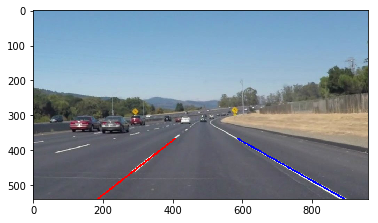

Processing image  whiteCarLaneSwitch.jpg with dimensions: (540, 960, 3)


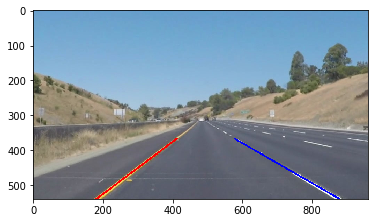

Processing image  solidYellowLeft.jpg with dimensions: (540, 960, 3)


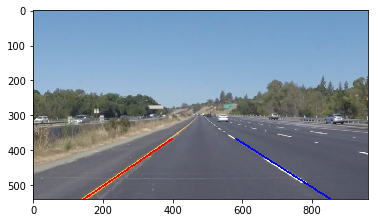

Processing image  solidYellowCurve2.jpg with dimensions: (540, 960, 3)


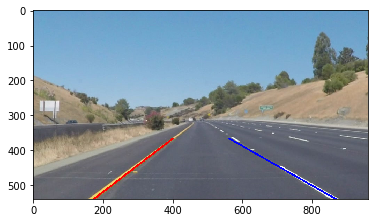

Processing image  solidYellowCurve.jpg with dimensions: (540, 960, 3)


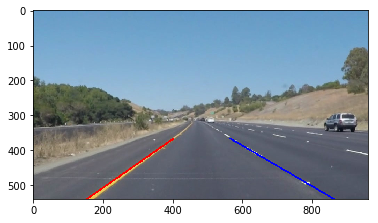

Processing image  solidWhiteRight.jpg with dimensions: (540, 960, 3)


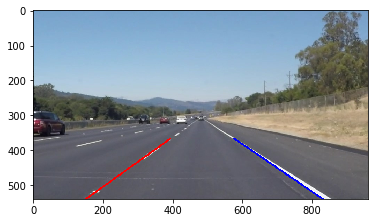

In [20]:
##############################################################################

# Process all vidoes in 'test_videos' and put them to 'result_videos'
videos = os.listdir("test_videos/")
for video in videos:
    if video.endswith(".mp4"):
       mark_video("test_videos/", "result_videos/", video)

# Process all images in 'test_images' and put them to 'result_images'
images = os.listdir("test_images/")
for image in images:
    if image.endswith(".jpg"):
        mark_image("test_images/", "result_images/", image)
